Utilisation de Prophet (Facebook) pour prédire la consommation d'léctrécité en France.<br>
data RTE : https://www.services-rte.com/en/download-data-published-by-rte.html?category=generation&type=actual_generations_per_production_type<br>

# Exercise 1 - energy data forecasting ⚡

Forecasting energy demand is big business and very important in helping energy producers maintain the balance within the electrical grid. You can find forecasts of energy demands for France in realtime [here](https://www.rte-france.com/fr/eco2mix/eco2mix-consommation). 

Your mission now is to use `Prophet` to make forecasts on the energy data you have already seen (in data viz module) for France! Feel free to choose : the type of energy france or region, and frequency scale you wish to try!

Consider the following as a reasonable first example:
* Daily forecast for an entire 1 year of 'consommation' in France

Consider that:
* Reducing the scale of the data, i.e. to regional
* Higher frequency predictions
* longer periods of forecast

...are likely to make it more difficult to make a good forecast.

Once you have made your model:
1. Compare it to a naive model
2. Try tuning the model in some way to improve performance (add holidays might be a good idea)
3. If you have time compare your model to an ARIMA model. Why might there be differences in perfomance between the two approachecs to forecasting?

## Import data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
# plt.rcParams.update({'font.size': 22})
import pickle

In [2]:
def ts_train_test_split(data, split_date):
    '''
    Split time series into training and test data
    
    Parameters:
    -------
    data - pd.DataFrame - time series data.  Index expected as datatimeindex
    split_date - the date on which to split the time series
    
    Returns:
    --------
    tuple (len=2) 
    0. pandas.DataFrame - training dataset
    1. pandas.DataFrame - test dataset
    '''
    train = data.loc[data.index < split_date]
    test = data.loc[data.index >= split_date]
    return train, test

def mean_absolute_percentage_error(y_true, y_pred): 
    '''
    MAPE

    Parameters:
    --------
    y_true -- np.array actual observations from time series
    y_pred -- the predictions to evaluate

    Returns:
    -------
    float, scalar value representing the MAPE (0-100)
    '''
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import numpy as np

def time_series_cv(model, error_func, train, val, horizons, step=1):
    '''
    Time series cross validation across multiple horizons for a single model.

    Incrementally adds additional training data to the model and tests
    across a provided list of forecast horizons. Note that function tests a
    model only against complete validation sets.  E.g. if horizon = 15 and 
    len(val) = 12 then no testing is done.  In the case of multiple horizons
    e.g. [7, 14, 28] then the function will use the maximum forecast horizon
    to calculate the number of iterations i.e if len(val) = 365 and step = 1
    then no. iterations = len(val) - max(horizon) = 365 - 28 = 337.
    
    Parameters:
    --------
    model - forecasting model

    error_func - function to measure forecast error

    train - np.array - vector of training data

    val - np.array - vector of validation data

    horizon - list of ints, forecast horizon e.g. [7, 14, 28] days

    step -- step taken in cross validation 
            e.g. 1 in next cross validation training data includes next point 
            from the validation set.
            e.g. 7 in the next cross validation training data includes next 7 points
            (default=1)
            
    Returns:
    -------
    np.array - vector of forecast errors from the CVs.
    '''
    cvs = []

    #change here: max(horizons) + 1
    for i in range(0, len(val) - max(horizons) + 1, step):
        
        train_cv = np.concatenate([train, val[:i]], axis=0)
        model.fit(train_cv)
        
        #predict the maximum horizon 
        preds = model.predict(horizon=len(val[i:i+max(horizons)]))

        horizon_errors = []
        for h in horizons:
            #would be useful to return multiple prediction errors in one go.
            pred_error = error_func(preds[:h], val[i:i+h])
            horizon_errors.append(pred_error)
        
        cvs.append(horizon_errors)
    
    return np.array(cvs)

In [5]:
# import pandas as pd

df_nat_raw = pd.read_csv('DATA_energy/df_nat.csv')
# data_nationales = pd.read_pickle("../data/df_data_nationales.pkl")
data_temperatures_raw = pd.read_pickle("DATA_energy/df_temperatures.pkl")

In [6]:
df_nat=df_nat_raw.copy()
df_temp = data_temperatures_raw.copy()

## Preprocess

### Set DateTime as index

In [7]:
df_nat = df_nat.set_index(pd.DatetimeIndex(df_nat['DateTime']))

### Dropna

In [8]:
df_nat.dropna(inplace=True)

In [9]:
df_nat.head(5)

DateTime  Consommation  Fioul  Charbon  \
DateTime                                                                 
2012-01-01 00:00:00  2012-01-01 00:00:00       58315.0  492.0     25.0   
2012-01-01 00:30:00  2012-01-01 00:30:00       58315.0  492.0     25.0   
2012-01-01 01:00:00  2012-01-01 01:00:00       56231.0  492.0     25.0   
2012-01-01 01:30:00  2012-01-01 01:30:00       56075.0  491.0     25.0   
2012-01-01 02:00:00  2012-01-01 02:00:00       55532.0  492.0     25.0   

                        Gaz  Nucléaire  Eolien  Solaire  Hydraulique  Pompage  \
DateTime                                                                        
2012-01-01 00:00:00  3816.0    52697.0  3588.0      0.0       7922.0  -1139.0   
2012-01-01 00:30:00  3816.0    52697.0  3588.0      0.0       7922.0  -1139.0   
2012-01-01 01:00:00  3834.0    51747.0  3536.0      0.0       7598.0  -1730.0   
2012-01-01 01:30:00  3832.0    51950.0  3526.0      0.0       7299.0  -2134.0   
2012-01-01 02:00:00  3839.0    51625.0  3535.0      0.0       7159.0  -2449.0   

                     Bioénergies  Ech. physiques  
DateTime                                          
2012-01-01 00:00:00        719.0         -9806.0  
2012-01-01 00:30:00        719.0         -9806.0  
2012-01-01 01:00:00        721.0         -9993.0  
2012-01-01 01:30:00        722.0         -9636.0  
2012-01-01 02:00:00        719.0         -9412.0

## Extract consumption/temperature and split train test

In [10]:
consumption = df_nat['Consommation'].copy()
consumption.head(5)

DateTime
2012-01-01 00:00:00    58315.0
2012-01-01 00:30:00    58315.0
2012-01-01 01:00:00    56231.0
2012-01-01 01:30:00    56075.0
2012-01-01 02:00:00    55532.0
Name: Consommation, dtype: float64

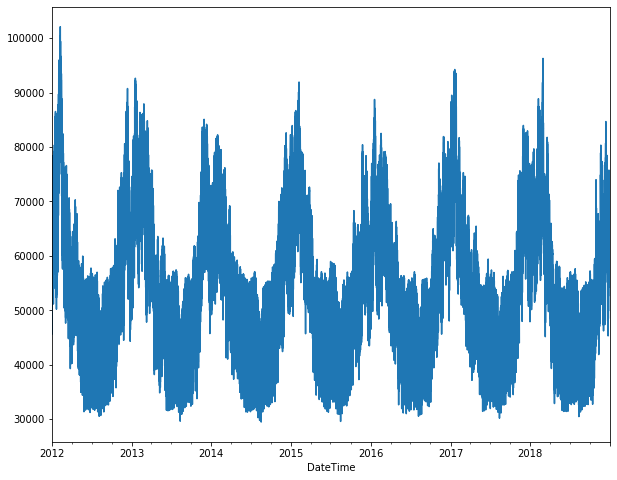

In [11]:
import matplotlib.pyplot as plt

consumption.plot()
plt.show()

In [12]:
consumption_daily = consumption.resample('1D').mean()

In [13]:
train, test = ts_train_test_split(consumption_daily, '2018-12-01')
train_log, test_log = np.log(train), np.log(test)

## Check for seasonality

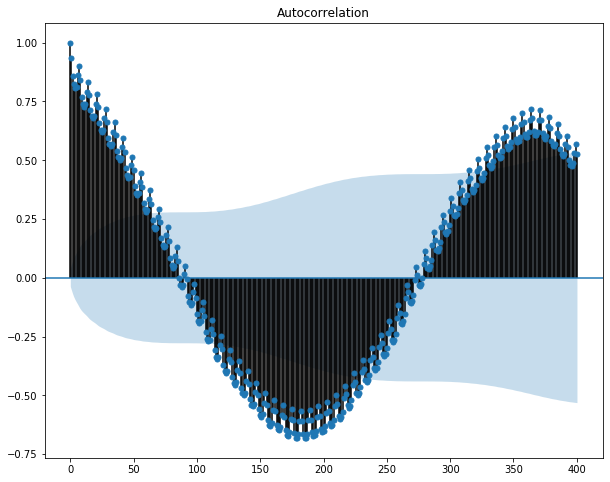

In [15]:
# Check for seasonality

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train, lags=400);

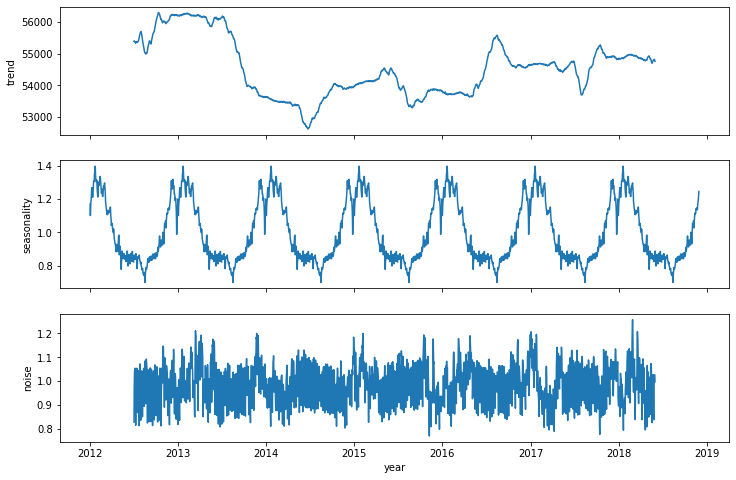

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

sd_result = seasonal_decompose(train,period=365,model='multiplicative')

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 8))

axes[0].figsize = (12, 10)

axes[0].plot(sd_result.trend)
axes[0].set(ylabel='trend');

axes[1].plot(sd_result.seasonal)
axes[1].set(ylabel='seasonality');

axes[2].plot(sd_result.resid)
axes[2].set(xlabel='year',ylabel='noise');

I see seasonality, but not really a trend

## Prepare data for exogenous input

In [17]:
df_temp_daily = df_temp.resample('1D').mean().mean(axis=1).copy()

In [18]:
df_temp_daily = pd.DataFrame({'DateTime':df_temp_daily.index, 'Temperature':df_temp_daily.values})
df_temp_daily = df_temp_daily.set_index(pd.DatetimeIndex(df_temp_daily['DateTime']))
df_temp_daily.drop('DateTime', axis=1, inplace=True)
df_consump_daily = pd.DataFrame({'DateTime':consumption_daily.index, 'Consumption':consumption_daily.values})
df_consump_daily = df_consump_daily.set_index(pd.DatetimeIndex(df_consump_daily['DateTime']))
df_consump_daily.drop('DateTime', axis=1, inplace=True)
df_merged = df_consump_daily.merge(df_temp_daily, left_index=True, right_index=True)

In [19]:
df_merged

Consumption  Temperature
DateTime                             
2013-01-01  54546.750000     4.900278
2013-01-02  64501.812500     5.798113
2013-01-03  66651.062500     7.229062
2013-01-04  65247.750000     8.283189
2013-01-05  60152.000000     7.726244
...                  ...          ...
2018-01-14  63638.562500     4.785503
2018-01-15  70662.416667     6.909080
2018-01-16  68532.270833     8.872216
2018-01-17  70484.104167     7.388270
2018-01-18  69634.875000     8.588575

[1844 rows x 2 columns]

In [126]:
# # Compute Seasonal Index
# from statsmodels.tsa.seasonal import seasonal_decompose
# from dateutil.parser import parse

# # multiplicative seasonal component
# result_mul = seasonal_decompose(df_merged['Consumption'],   
#                                 model='additive', 
#                                 extrapolate_trend='freq',
#                                 period=365)

# df_merged['Seasonal_index'] = result_mul.seasonal.to_frame()

## Fit autoARIMA

In [ ]:
df_merged_log = df_merged.copy()
df_merged_log.Consumption = np.log(df_merged_log.Consumption)

import pmdarima as pm

# SARIMAX Model
sxmodel = pm.auto_arima(df_merged_log[['Consumption']], 
                        exogenous=df_merged[['Temperature']], m=365, verbose=1)
#                            start_p=1, start_q=1,
#                            test='adf',
#                            max_p=3, max_q=3, m=12,)
#                            start_P=0, seasonal=True,
#                            d=None, D=1, trace=True,
#                            error_action='ignore',  
#                            suppress_warnings=True, 
#                            stepwise=True)

sxmodel.summary()

/home/campus-5/anaconda3/envs/forecast/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/campus-5/anaconda3/envs/forecast/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/campus-5/anaconda3/envs/forecast/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/campus-5/anaconda3/envs/forecast/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting M

## Forecast

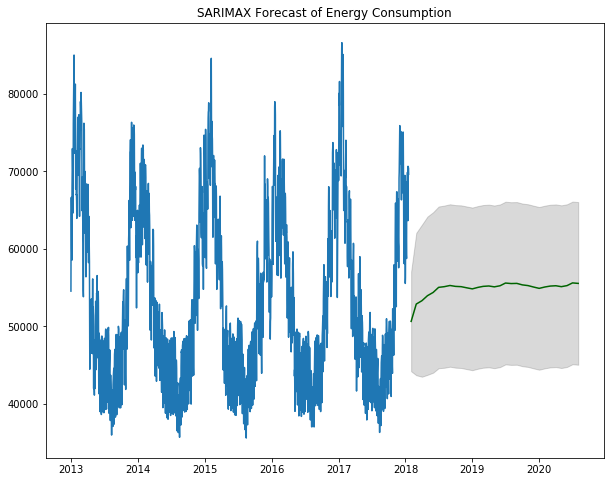

In [145]:
# Forecast
n_periods = 31
fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=df_merged[['Temperature']][-31:], 
                                  return_conf_int=True)

forecast_index = pd.date_range(start=df_merged.index[-31],periods=n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_merged[['Consumption']])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast of Energy Consumption")
plt.show()

### Cross validation

In [19]:
from pmdarima.arima import ARIMA
model = ARIMA(order=(2,0,0), seasonal_order=(0, 1, 1, 12), suppress_warnings = True, n_jobs=-1)

In [20]:
model.fit(train)

ARIMA(maxiter=50, method='lbfgs', order=(2, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 1, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

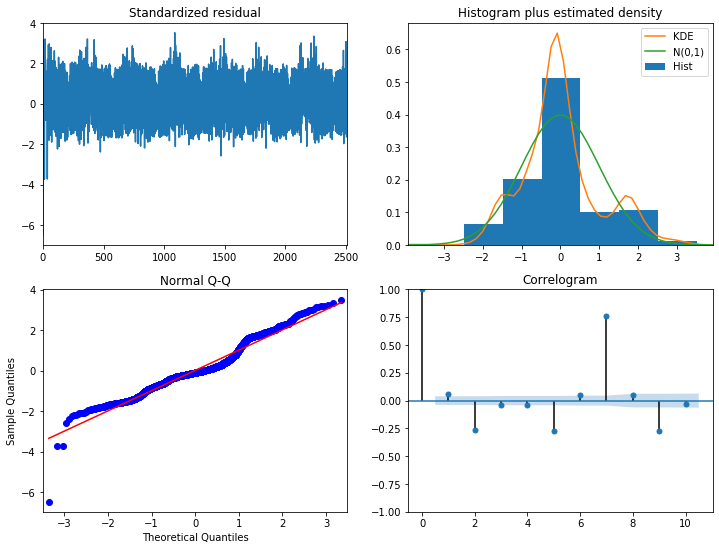

In [21]:
model.plot_diagnostics(figsize=(12,9));

In [ ]:
from pmdarima.model_selection import RollingForecastCV, cross_val_score

cv = RollingForecastCV(h=31, step=31)

cv_results = cross_val_score(model, train, cv=cv, scoring=mean_absolute_percentage_error)
print('Step = ',st)
print('='*50)
print(pd.DataFrame(cv_results).dropna().describe())

In [ ]:
from pmdarima.arima import auto_arima

a_arima = auto_arima(train, seasonal=True, m=365, suppress_warnings=True, n_jobs=-1) # m here is my seasonality
a_arima.summary()

/home/campus-2/anaconda3/envs/forecast/lib/python3.8/site-packages/pmdarima/arima/auto.py:301: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


In [ ]:
a_arima.plot_diagnostics(figsize=(12,9));

In [ ]:
from pmdarima.model_selection import RollingForecastCV, cross_val_score

st=10
cv = RollingForecastCV(h=10, step=st)

cv_results = cross_val_score(a_arima, train, cv=cv, scoring=mean_absolute_percentage_error)
print('Step = ',st)
print('='*50)
print(pd.DataFrame(cv_results).dropna().describe())

## Prediction

In [ ]:
a_arima.fit(consumption_daily)

consumption_daily_forecast, confint = a_arima.predict(n_periods=365, return_conf_int=True, alpha=0.05)

In [ ]:
#create an datetime index for the forecast horizon
consumption_daily_index = pd.date_range(start='2019-01-01', periods=365, freq='D')

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(pd.Series(consumption_daily_forecast, index=consumption_daily_index));
axes[0].plot(consumption_daily)

axes[0].set(ylabel='Consumption');

limits = pd.DataFrame(confint, index=lynx_forecast_index, columns=['lower', 'upper'])
axes[0].fill_between(consumption_daily_index, limits['lower'], limits['upper'], 
                  alpha=.3, 
                  label='95% CI')

axes[0].legend(['Existing data', 'Forecast', '95% CI']);

axes[1].plot(pd.Series(consumption_daily_forecast, index=consumption_daily_index));
axes[1].set(ylabel='Number of skins');

axes[1].fill_between(consumption_daily_index, limits['lower'], limits['upper'], 
                  alpha=.1, 
                  label='95% CI', color='blue')

axes[1].legend(['Forecast', '95% CI']);

## Forecast with Prophet

In [23]:
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters() # required to fix plotting bug introduced by prophet

### Convert dataframe used to work with Prophet

In [24]:
train_df = pd.DataFrame(train).reset_index().rename(columns = {'Consommation':'y','DateTime':'ds'})
train_df.head()

ds             y
0 2012-01-01  51491.500000
1 2012-01-02  60683.645833
2 2012-01-03  67762.104167
3 2012-01-04  68029.229167
4 2012-01-05  69157.395833

In [55]:
model = Prophet(interval_width=0.95)
model.fit(train_df)
future = model.make_future_dataframe(periods=31, freq='D', include_history=True)
# future.head()
forecast = model.predict(future)
y_pred = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds')
mean_absolute_percentage_error(test.values , forecast['yhat'][-31:])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


9.250796811005783

In [56]:
future

ds
0    2012-01-01
1    2012-01-02
2    2012-01-03
3    2012-01-04
4    2012-01-05
...         ...
2552 2018-12-27
2553 2018-12-28
2554 2018-12-29
2555 2018-12-30
2556 2018-12-31

[2557 rows x 1 columns]

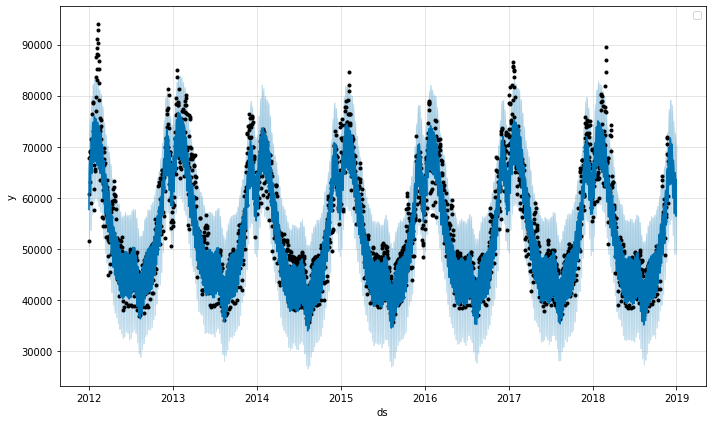

In [57]:
fig = model.plot(forecast)
# test.plot(style='.r')
plt.legend()
plt.show()

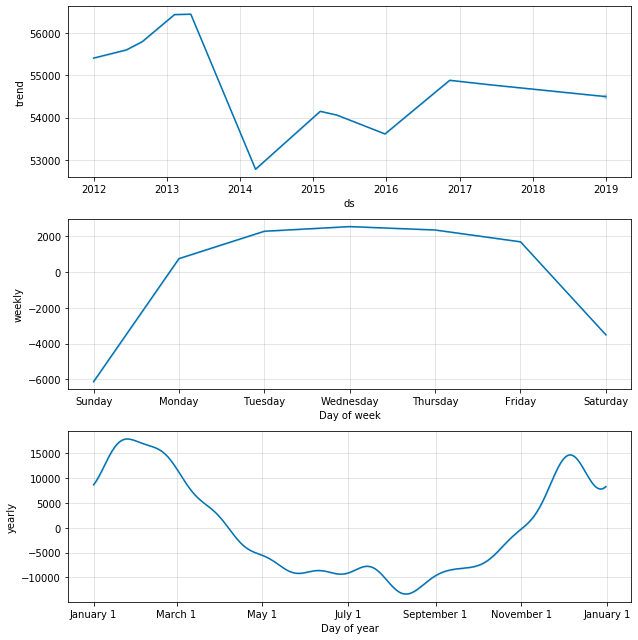

In [58]:
model.plot_components(forecast);

## Naive models

### Cross validation

In [48]:
from forecast.baseline import SNaive

HORIZON = 31 # we plan to make forecasts for the following 10 years
PERIOD = 31 # period is the period of seasonality we expect

# using seasonal naive
snf = SNaive(period=PERIOD)
snf.fit(train)

trainCV_adj, valCV_adj = train.iloc[:365*5], train.iloc[365*5:]
cv_scores = time_series_cv(snf, 
                           error_func=mean_absolute_percentage_error,
                           train=trainCV_adj,
                           val=valCV_adj,
                           horizons=[HORIZON],
                           step=PERIOD)
cv_scores = pd.DataFrame(cv_scores)
cv_scores.describe()
print('MAPE = ',round(cv_scores.describe().iloc[1][0],2),'%')
print('std = ',round(cv_scores.describe().iloc[2][0],2),'%')

MAPE =  14.57 %
std =  4.71 %


### Prediction

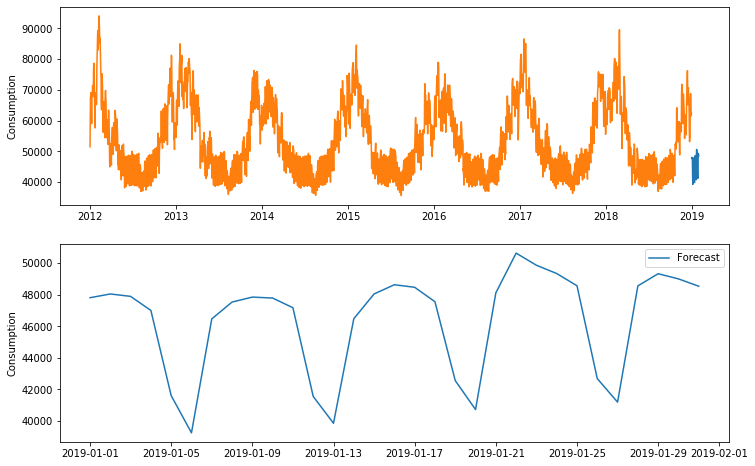

In [49]:
snf_forecast = snf.predict(31)
snf_forecast_index = pd.date_range(start='2019-01-01', periods=31, freq='D')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].plot(pd.Series(snf_forecast, index=snf_forecast_index));
axes[0].plot(consumption_daily)
axes[0].set(ylabel='Consumption');
# limits = pd.DataFrame(confint, index=lynx_forecast_index, columns=['lower', 'upper'])
# axes[0].fill_between(lynx_forecast_index, limits['lower'], limits['upper'], 
#                   alpha=.3, 
#                   label='95% CI')
# axes[0].legend(['Existing data', 'Forecast', '95% CI']);
axes[1].plot(pd.Series(snf_forecast, index=snf_forecast_index));
axes[1].set(ylabel='Consumption');
# axes[1].fill_between(lynx_forecast_index, limits['lower'], limits['upper'], 
#                   alpha=.1, 
#                   label='95% CI', color='blue')
# axes[1].legend(['Forecast', '95% CI']);
axes[1].legend(['Forecast']);

### Cross validation

In [59]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [60]:
model = Prophet()
model.fit(train_df)
df_cv = cross_validation(model, initial='1825 days', period='31 days', horizon = '31 days')
df_cv.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 22 forecasts with cutoffs between 2017-01-17 00:00:00 and 2018-10-30 00:00:00


ds          yhat    yhat_lower    yhat_upper             y  \
0 2017-01-18  77167.999634  72557.985490  81949.179579  85886.520833   
1 2017-01-19  77328.080170  72360.001371  82029.034075  86614.687500   
2 2017-01-20  76972.090857  72414.724929  81763.859367  85613.458333   
3 2017-01-21  71950.178294  67011.159776  76743.111545  79169.916667   
4 2017-01-22  69435.305117  64534.079867  74594.553395  75799.145833   

      cutoff  
0 2017-01-17  
1 2017-01-17  
2 2017-01-17  
3 2017-01-17  
4 2017-01-17

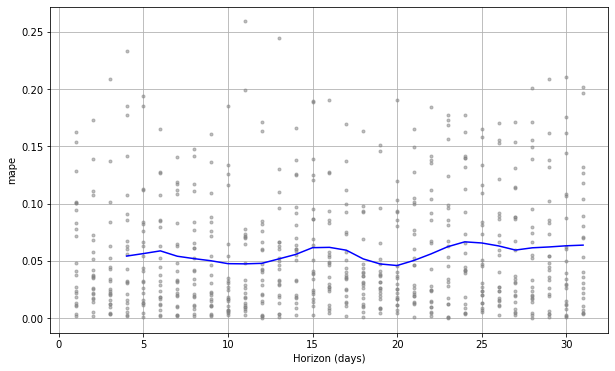

In [61]:
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()

In [62]:
print('MAPE = ',round(df_p.describe().mape[1]*100,2),'%')
print('std = ',round(df_p.describe().mape[2]*100,2),'%')

MAPE =  5.63 %
std =  0.63 %


## Back to Prophet - Improvements

Score to beat: MAPE =  5.63 %      std =  0.63 %

In [63]:
model = Prophet(growth='linear',
                changepoints=None,
                n_changepoints=25,
                changepoint_range=0.8,
                yearly_seasonality='auto',
                weekly_seasonality='auto',
                daily_seasonality='auto',
                holidays_prior_scale=10.0,
                changepoint_prior_scale=0.05,
                stan_backend=None,
                mcmc_samples=0,interval_width=0.8,
                seasonality_mode='multiplicative',
                seasonality_prior_scale=10,
                uncertainty_samples=1000,
).add_country_holidays('France')

model.fit(train_df)
df_cv = cross_validation(model, initial='1825 days', period='31 days', horizon = '31 days')
df_p = performance_metrics(df_cv)
print('MAPE = ',round(df_p.describe().mape[1]*100,2),'%')
print('std = ',round(df_p.describe().mape[2]*100,2),'%')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 22 forecasts with cutoffs between 2017-01-17 00:00:00 and 2018-10-30 00:00:00


MAPE =  5.51 %
std =  0.68 %


In [67]:
model = Prophet(growth='linear',
                changepoints=None,
                n_changepoints=365,
                changepoint_range=0.8,
                yearly_seasonality='auto',
                weekly_seasonality='auto',
                daily_seasonality='auto',
                holidays_prior_scale=10.0,
                changepoint_prior_scale=0.05,
                stan_backend=None,
                mcmc_samples=0,interval_width=0.8,
                seasonality_mode='multiplicative',
                seasonality_prior_scale=10,
                uncertainty_samples=1000,
).add_country_holidays('France')

model.fit(train_df)
df_cv = cross_validation(model, initial='1825 days', period='31 days', horizon = '31 days')
df_p = performance_metrics(df_cv)
print('MAPE = ',round(df_p.describe().mape[1]*100,2),'%')
print('std = ',round(df_p.describe().mape[2]*100,2),'%')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 22 forecasts with cutoffs between 2017-01-17 00:00:00 and 2018-10-30 00:00:00


MAPE =  5.52 %
std =  0.67 %


### Final prediction

In [68]:
import plotly
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()

#### Prepare data

In [69]:
consumption_daily_final = pd.DataFrame(consumption_daily).reset_index().rename(columns = {'Consommation':'y','DateTime':'ds'})
consumption_daily_final.head()

ds             y
0 2012-01-01  51491.500000
1 2012-01-02  60683.645833
2 2012-01-03  67762.104167
3 2012-01-04  68029.229167
4 2012-01-05  69157.395833

In [72]:
model = Prophet(growth='linear',
                changepoints=None,
                n_changepoints=25,
                changepoint_range=0.8,
                yearly_seasonality='auto',
                weekly_seasonality='auto',
                daily_seasonality='auto',
                holidays_prior_scale=10.0,
                changepoint_prior_scale=0.05,
                stan_backend=None,
                mcmc_samples=0,interval_width=0.8,
                seasonality_mode='multiplicative',
                seasonality_prior_scale=10,
                uncertainty_samples=1000,
).add_country_holidays('France')
model.fit(consumption_daily_final)

future_consumption = model.make_future_dataframe(periods=31)
forecast = model.predict(future_consumption)
df_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df_forecast.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds          yhat    yhat_lower    yhat_upper
0 2012-01-01  53474.234204  48500.692413  58274.656352
1 2012-01-02  66253.871822  61495.529309  70931.754440
2 2012-01-03  68044.795429  62996.187847  72640.733764
3 2012-01-04  68656.505401  63923.678688  73020.746132
4 2012-01-05  69055.330309  64378.619355  74000.558896

In [74]:
trace_open = go.Scatter(
    x = df_forecast["ds"],
    y = df_forecast["yhat"],
    mode = 'lines',
    name="Forecast"
)

trace_high = go.Scatter(
    x = df_forecast["ds"],
    y = df_forecast["yhat_upper"],
    mode = 'lines',
    fill = "tonexty", 
    line = {"color": "#57b8ff"}, 
    name="Higher uncertainty interval"
)

trace_low = go.Scatter(
    x = df_forecast["ds"],
    y = df_forecast["yhat_lower"],
    mode = 'lines',
    fill = "tonexty", 
    line = {"color": "#57b8ff"}, 
    name="Lower uncertainty interval"
)

trace_close = go.Scatter(
    x = consumption_daily_final["ds"],
    y = consumption_daily_final["y"],
    name="Data values"
)

data = [trace_open,trace_high,trace_low,trace_close]

layout = go.Layout(title="Consumption Forecast",xaxis_rangeslider_visible=True)

fig = go.Fi8gure(data=data,layout=layout)

plotly.offline.iplot(fig)